In [1]:
EPOCHS = 200
BATCH = 1000
THRESHOLD = 0.5
PLOTS_DIR = "plots/"
DATA_DIR = "data/"
MODEL_DIR = "model/"

In [2]:
import sys, os, pickle
from keras.models import Sequential, model_from_json
import pandas as pd
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop, SGD
import sys, re, glob
import numpy as np
from keras.layers import Input, Dense, Flatten
import sys, re, glob
import pandas as pd
import numpy as np
from lxml import etree
from sklearn.model_selection import StratifiedKFold 
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle, product
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from multiprocessing.pool import Pool
from functools import partial
from sklearn.model_selection import train_test_split
import time

Using TensorFlow backend.


In [3]:
np.random.seed(7)

# Data

In [4]:
no_attack = pd.read_csv(DATA_DIR + "no_attack.csv")
greyhole_attack = pd.read_csv(DATA_DIR + "greyhole_attack.csv")
wormhole_attack = pd.read_csv(DATA_DIR + "wormhole_attack.csv")
blackhole_attack = pd.read_csv(DATA_DIR + "blackhole_attack.csv")
ddos_attack = pd.read_csv(DATA_DIR + "ddos_attack.csv")

In [5]:
no_attack.drop("Type",axis=1, inplace=True)
greyhole_attack.drop("Type",axis=1, inplace=True)
wormhole_attack.drop("Type",axis=1, inplace=True)
blackhole_attack.drop("Type",axis=1, inplace=True)
ddos_attack.drop("Type",axis=1, inplace=True)

In [6]:
X = np.concatenate((no_attack, blackhole_attack)).astype(np.float)
y = np.concatenate((np.zeros((1000, 1)), np.ones((1000, 1))))

In [7]:
indexes = np.array(range(len(y)))
np.random.shuffle(indexes)
indexes
X = X[indexes]
y = y[indexes]

In [8]:
X[np.isnan(X)] = 0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=17)

# Model

In [10]:
class GAN:
    def __init__(self, shape, 
                 generator_params = [2, [5, 3]], 
                 discriminator_params = [2, [5, 3]]):
        self.SHAPE = shape
        self.generator_params = generator_params
        self.discriminator_params = discriminator_params
        self.compile_models()

    def __generator(self):
        n_layers, n_nuerons = self.generator_params
        
        model = Sequential()        
        for i in range(n_layers):
            model.add(Dense(n_nuerons[i], kernel_initializer='uniform',  activation='relu',))
            
        model.add(Dense(self.SHAPE, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        
        return model
    
    def __discriminator(self):
        n_layers, n_nuerons = self.generator_params
        
        model = Sequential()        
        for i in range(n_layers):
            model.add(Dense(n_nuerons[i], kernel_initializer='uniform',  activation='relu',))
        
        model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model
    
    def __stacked(self, generator, discriminator):
        discriminator.trainable = False
        model = Sequential()
        model.add(generator)
        model.add(discriminator)
        return model
    
    def compile_models(self):
        self.generator = self.__generator()
        self.discriminator = self.__discriminator()
        self.stacked = self.__stacked(self.generator, self.discriminator)
        self.stacked.compile(loss='mean_squared_error', optimizer='adam')
        
        
    def save_models(self, path="data/"):
        if not os.path.exists(path):
            os.makedirs(path)        
        
        self.generator.save_weights(path + "generator_weights.h5")
        self.discriminator.save_weights(path +  "discriminator_weights.h5")
        self.stacked.save_weights(path +  "stacked_weights.h5")
        
        with open(path +  "generator_model.json", "w") as json_file:
            json_file.write(self.generator.to_json())
        
        with open(path +  "discriminator_model.json", "w") as json_file:
            json_file.write(self.discriminator.to_json())
            
        with open(path +  "stacked_model.json", "w") as json_file:
            json_file.write(self.stacked.to_json())
            
            
    def load_models(self, path="data/"):
        with open(path +  "generator_model.json", "r") as json_file:
            self.generator = model_from_json(json_file.read())
            self.generator.load_weights(path +  "generator_weights.h5")
            
        with open(path +  "discriminator_model.json", "r") as json_file:
            self.discriminator = model_from_json(json_file.read())
            self.discriminator.load_weights(path +  "discriminator_weights.h5")
            
        with open(path +  "stacked_model.json", "r") as json_file:
            self.stacked = model_from_json(json_file.read())
            self.stacked.load_weights(path +  "stacked_weights.h5")
            
        self.generator.compile(loss='binary_crossentropy', optimizer='adam')
        self.discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )
        self.stacked.compile(loss='binary_crossentropy', optimizer='adam')
                    
    
    def train(self,X, y, epochs=200, batch = 100, debug=False):        
        for cnt in range(epochs):

            ## train discriminator
            random_index =  np.random.randint(0, len(y) - batch)
            X_batch = X[random_index : random_index + batch]
            y_batch = y[random_index : random_index + batch]

            gen_noise = np.random.normal(0, 1, (batch,10))
            syntetic = self.generator.predict(gen_noise)
                
            x_combined_batch = np.concatenate((X_batch, syntetic))
            y_combined_batch = np.concatenate((y_batch, np.zeros((batch, 1))))

            d_loss = self.discriminator.train_on_batch(x_combined_batch, y_combined_batch)

            # train generator
            noise = np.random.normal(0, 1, (batch,10))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked.train_on_batch(noise, y_mislabled)
            
            if debug:            
                random_index =  np.random.randint(0, len(y) - batch // 10)
                X_batch_test = X[random_index : random_index + batch // 10]
                y_batch_test = y[random_index : random_index + batch // 10]
                predict = self.discriminator.predict(X_batch_test)
                f = metrics.f1_score(y_batch_test, (predict > 0.5), average='macro')
                print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f], [ F1: %f]' % (cnt, d_loss[0], g_loss, f))

# Train

In [11]:
SHAPE = X.shape[1]

In [12]:
gan = GAN(SHAPE)
gan.train(X_train, y_train, epochs=EPOCHS, batch=BATCH, debug=True)

/home/vanet/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch: 0, [Discriminator :: d_loss: 1.542867], [ Generator :: loss: 0.250184], [ F1: 0.324324]
epoch: 1, [Discriminator :: d_loss: 1.522772], [ Generator :: loss: 0.250184], [ F1: 0.367089]
epoch: 2, [Discriminator :: d_loss: 1.515493], [ Generator :: loss: 0.250184], [ F1: 0.401198]
epoch: 3, [Discriminator :: d_loss: 1.515137], [ Generator :: loss: 0.250183], [ F1: 0.342105]
epoch: 4, [Discriminator :: d_loss: 1.505749], [ Generator :: loss: 0.250183], [ F1: 0.285714]
epoch: 5, [Discriminator :: d_loss: 1.503977], [ Generator :: loss: 0.250186], [ F1: 0.358974]
epoch: 6, [Discriminator :: d_loss: 1.498187], [ Generator :: loss: 0.250195], [ F1: 0.319728]
epoch: 7, [Discriminator :: d_loss: 1.485510], [ Generator :: loss: 0.250194], [ F1: 0.319728]
epoch: 8, [Discriminator :: d_loss: 1.504432], [ Generator :: loss: 0.250191], [ F1: 0.349773]
epoch: 9, [Discriminator :: d_loss: 1.516980], [ Generator :: loss: 0.250188], [ F1: 0.319728]
epoch: 10, [Discriminator :: d_loss: 1.484613], [ 

epoch: 88, [Discriminator :: d_loss: 1.882472], [ Generator :: loss: 0.249981], [ F1: 0.319728]
epoch: 89, [Discriminator :: d_loss: 1.915445], [ Generator :: loss: 0.249977], [ F1: 0.280576]
epoch: 90, [Discriminator :: d_loss: 1.913372], [ Generator :: loss: 0.249970], [ F1: 0.346405]
epoch: 91, [Discriminator :: d_loss: 1.962151], [ Generator :: loss: 0.249964], [ F1: 0.315068]
epoch: 92, [Discriminator :: d_loss: 1.965192], [ Generator :: loss: 0.249958], [ F1: 0.378882]
epoch: 93, [Discriminator :: d_loss: 2.011070], [ Generator :: loss: 0.249958], [ F1: 0.305556]
epoch: 94, [Discriminator :: d_loss: 1.996733], [ Generator :: loss: 0.249957], [ F1: 0.310345]
epoch: 95, [Discriminator :: d_loss: 2.043175], [ Generator :: loss: 0.249953], [ F1: 0.350312]
epoch: 96, [Discriminator :: d_loss: 2.036700], [ Generator :: loss: 0.249951], [ F1: 0.340436]
epoch: 97, [Discriminator :: d_loss: 2.078599], [ Generator :: loss: 0.249947], [ F1: 0.388112]
epoch: 98, [Discriminator :: d_loss: 2.1

epoch: 173, [Discriminator :: d_loss: 4.353559], [ Generator :: loss: 0.196910], [ F1: 0.315068]
epoch: 174, [Discriminator :: d_loss: 4.349462], [ Generator :: loss: 0.193936], [ F1: 0.367089]
epoch: 175, [Discriminator :: d_loss: 4.361466], [ Generator :: loss: 0.190933], [ F1: 0.264706]
epoch: 176, [Discriminator :: d_loss: 4.293777], [ Generator :: loss: 0.187904], [ F1: 0.300699]
epoch: 177, [Discriminator :: d_loss: 4.298151], [ Generator :: loss: 0.184795], [ F1: 0.315068]
epoch: 178, [Discriminator :: d_loss: 4.350420], [ Generator :: loss: 0.181526], [ F1: 0.354839]
epoch: 179, [Discriminator :: d_loss: 4.331287], [ Generator :: loss: 0.178136], [ F1: 0.363057]
epoch: 180, [Discriminator :: d_loss: 4.360018], [ Generator :: loss: 0.174895], [ F1: 0.324324]
epoch: 181, [Discriminator :: d_loss: 4.365026], [ Generator :: loss: 0.171462], [ F1: 0.342105]
epoch: 182, [Discriminator :: d_loss: 4.386211], [ Generator :: loss: 0.167966], [ F1: 0.363057]
epoch: 183, [Discriminator :: 

# Model saving

In [13]:
gan.save_models(MODEL_DIR)

# Predict

In [14]:
score = gan.discriminator.predict(X_test)
predict = score > THRESHOLD

# Metrics

### Cross validation

In [15]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) 
f_scores = [] 
acc_scores = [] 
for train, test in kfold.split(X, y): 
    __X_train , __X_test , __y_train, __y_test = X[train], X[test], y[train], y[test]
    __gan = GAN(SHAPE)
    __gan.train(__X_train, __y_train, epochs=EPOCHS, batch=BATCH, debug=False)
    __score = gan.discriminator.predict(__X_test) 
    f_scores.append(metrics.f1_score(__y_test, (__score > THRESHOLD)))
    acc_scores.append(metrics.accuracy_score(__y_test, (__score > THRESHOLD)) ) 
    
print("F score: %.2f%% (+/- %.2f%%)" % (np.mean(f_scores), np.std(f_scores)))
print("Accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(acc_scores), np.std(acc_scores)))

F score: 0.67% (+/- 0.00%)
Accuracy: 0.50% (+/- 0.00%)


### Confusion matrix

Confusion matrix, without normalization
[[  0 330]
 [  0 330]]


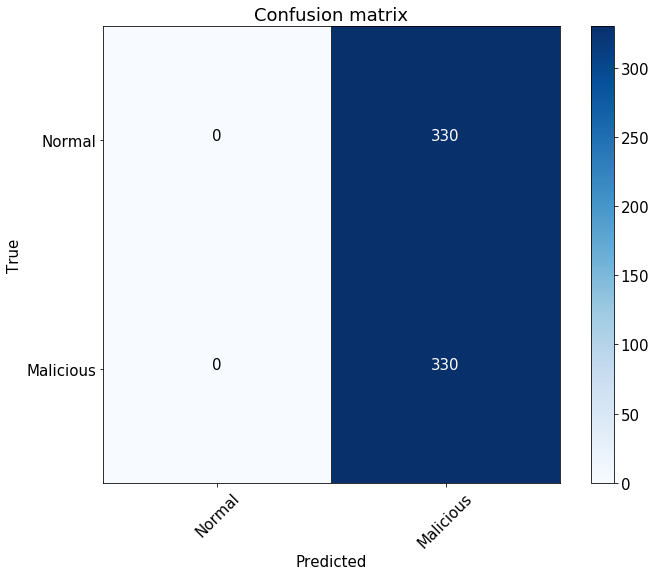

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)  
    
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = metrics.confusion_matrix(y_test, (predict))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Malicious'], title='Confusion matrix')
plt.savefig(PLOTS_DIR + 'confusion_matrix.png', dpi=80)
plt.show()

### ROC

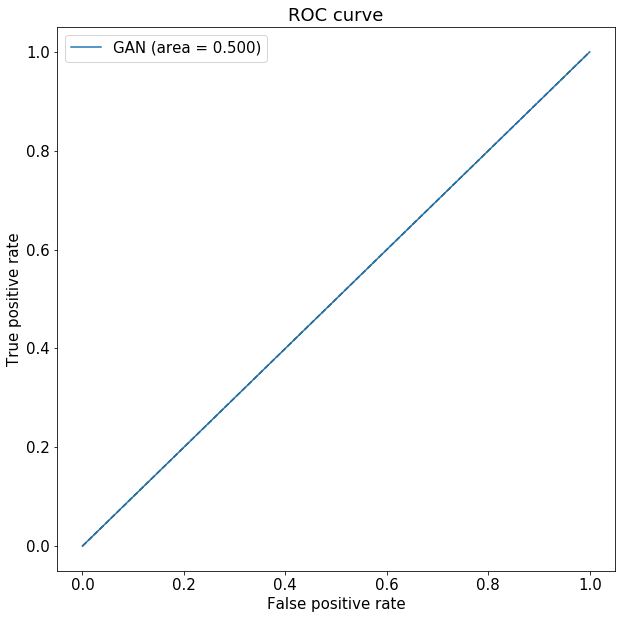

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, score)
pd.DataFrame(data={"TPR": tpr, "FPR": fpr, "thresholds": thresholds}).to_csv(PLOTS_DIR + "roc.csv")
auc_gan = auc(fpr, tpr)
plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='GAN (area = {:.3f})'.format(auc_gan))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)  
plt.savefig(PLOTS_DIR + 'roc.png', dpi=80)
plt.show()

### Prcision recall

No handles with labels found to put in legend.


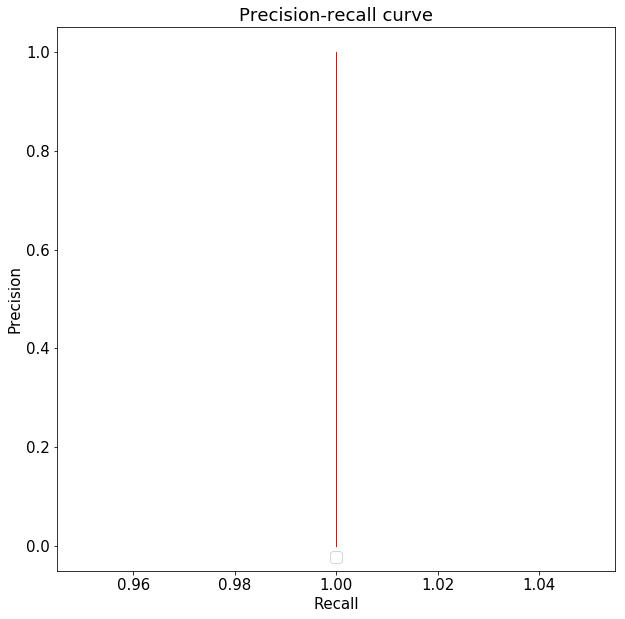

In [22]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, score)
thresholds = np.append(thresholds, 1.0)
pd.DataFrame(data={"precision": precision, "recall": recall, "thresholds": thresholds}).to_csv(PLOTS_DIR + "pr.csv")

plt.figure(figsize=(10, 10))
plt.plot(thresholds, precision,lw=1, color='green')
plt.plot(thresholds, recall, lw=1,color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower center')
plt.title('Precision-recall curve')

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)  
plt.savefig(PLOTS_DIR + 'precision_recall.png', dpi=80)
plt.show()

### Зависимость f-меры, времени обучения и тестирования от количества нейронов

In [25]:
n_layers = 3
n_neurons_list = np.fromfunction(lambda i: 10+i*i, (20,), dtype=int)

time_fit = []
time_predict = []
f_score = []

for n_neurons in n_neurons_list:
    n_neurons = [n_neurons_list[0]]*n_layers
    __gan = GAN(shape = SHAPE, discriminator_params=[n_layers, n_neurons])
    
    s = time.time()
    __gan.train(X_train, y_train, epochs=EPOCHS, batch=BATCH)
    time_fit.append(time.time() - s)
    
    s = time.time()
    __predict = __gan.discriminator.predict(X_test) > THRESHOLD
    time_predict.append(time.time() - s)
    
    f_score.append(metrics.f1_score(y_test, __predict, average='macro'))
    
if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)      
pd.DataFrame(data={"n_neurons_list": n_neurons_list, "time_fit": time_fit, "time_predict": time_predict, "f_score": f_score}).to_csv(PLOTS_DIR + "n_neurons.csv")

/home/vanet/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


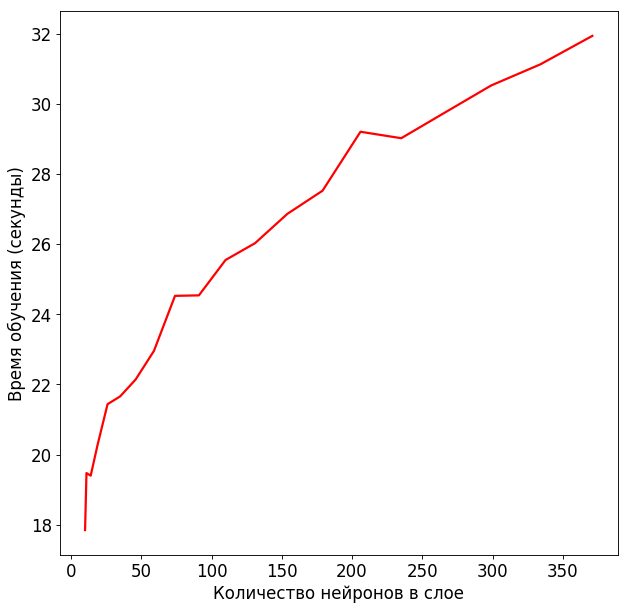

In [26]:
plt.figure(1, figsize=(9, 9), dpi=80)
plt.plot(n_neurons_list, time_fit, color="red",lw=2)  
plt.title('')
plt.ylabel('Время обучения (секунды)', fontsize=15)
plt.xlabel('Количество нейронов в слое', fontsize=15)
plt.savefig(PLOTS_DIR + 'predict_time_neurons_n.png')
plt.show()

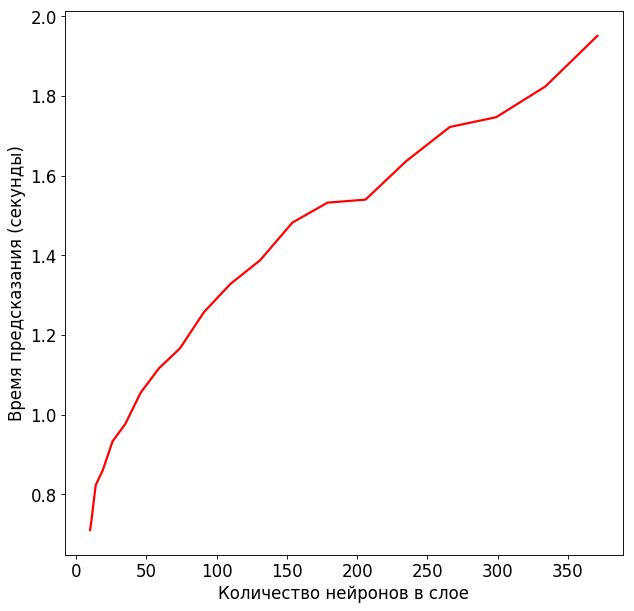

In [27]:
plt.figure(1, figsize=(9, 9), dpi=80)
plt.plot(n_neurons_list, time_predict, color="red",lw=2)  
plt.title('')
plt.ylabel('Время предсказания (секунды)', fontsize=15)
plt.xlabel('Количество нейронов в слое', fontsize=15)
plt.savefig(PLOTS_DIR + 'fit_time_neurons_n.png')
plt.show()

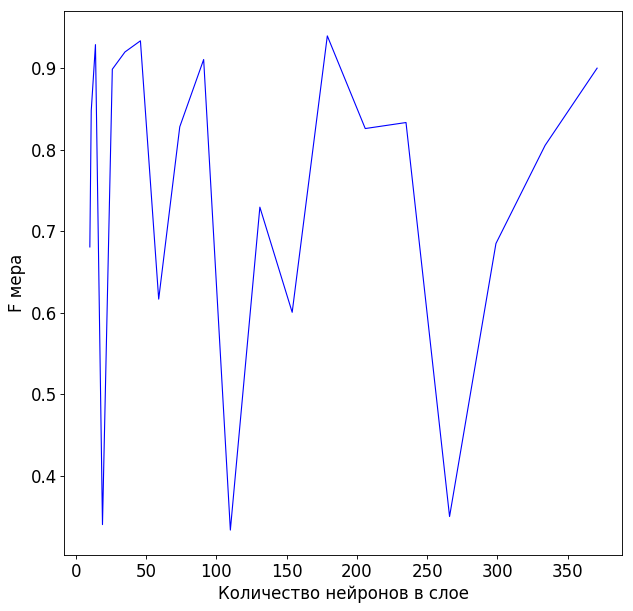

In [28]:
plt.figure(1, figsize=(9, 9), dpi=80)
plt.plot(n_neurons_list, f_score, color="blue",lw=1 )  
plt.title('')
plt.ylabel('F мера', fontsize=15)
plt.xlabel('Количество нейронов в слое', fontsize=15)
plt.savefig(PLOTS_DIR + 'f1_neurons_n.png')
plt.show()